# Gas2VecKNN

take the gas2vec peak and spectral vectors and

1. compute cosine similarity between discovered peaks' vectors and all others

2. get spectral embedding of discovered peaks, compute cosine similarity against all others



## Settings

In [48]:
base = "data"
dataset = "nist"
kind = "in_database"


wv_path = f"gas2vec/{kind}.model"

data_train_path =f"{base}/{dataset}/{kind}/train.msp"
data_val_path =f"{base}/{dataset}/{kind}/val.msp"
data_test_path =f"{base}/{dataset}/{kind}/test.msp"


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# compounds to visualize 
if kind == "in_database":
    interesting =  ["Atrazine", "Carbofuran", "Monocrotophos", "Mevinphos", "Testosterone"]
elif kind == "de_novo":
    interesting =  ["Metobromuron", "Picoxystrobin", "Cyphenothrin", "Mirex"]

In [50]:
from gensim.models import Word2Vec

w2v = Word2Vec.load(wv_path)
vocab = {e:i for i, e in enumerate(w2v.wv.index2entity)}


## Data loading

In [51]:
from matchms.importing import load_from_msp
from spec2vec import SpectrumDocument
from data_utils import spectrum_processing
from data_utils import IntegerMzCoder, TextMzCoder, TopKDS, GenDS

In [52]:
def load_process_documents(path):
    # Load data from MSP file and apply filters
    spectrums = [spectrum_processing(s) for s in load_from_msp(path)]
    # Omit spectrums that didn't qualify for analysis
    spectrums = [s for s in spectrums if s is not None]
    # Create spectrum documents
    documents = [SpectrumDocument(s, n_decimals=0) for s in spectrums]
    return documents
#documents_train = load_process_documents(data_train_path)
documents_val = load_process_documents(data_val_path)
documents_test = load_process_documents(data_test_path)



In [53]:
datasets = {
   # "gen_train": GenDS(documents_train, vocab, onehot=False), 
    "gen_val": GenDS(documents_val, vocab, onehot=False), 
    "gen_test": GenDS(documents_test, vocab,onehot=False), 
}

## Models definition

In [54]:
from helpers import get_top_k_ind
from collections import Counter
import numpy as np

In [71]:
from sklearn.metrics.pairwise import cosine_similarity

class PeakKNN():
    def __init__(self, w2v, weighted=True, weight_power=.5, index2relfreq=None):
        self.w2v = w2v
        self.embeddings = w2v.wv.vectors
        self.weighted = weighted
        self.weight_power = weight_power
        self.index2relfreq = index2relfreq
 
        
    def __call__(self, indices_batch, intens_batch=None, prior=False):
        """
        indices_batch: list of np arrays containing embedding indices of peaks
        """
        
        res = np.zeros(shape=(len(indices_batch), len(self.embeddings)))
        for i, indices in enumerate(indices_batch):
        
            sim_matrix = cosine_similarity(self.embeddings[indices], self.embeddings)
            
            if not self.weighted:
                weights = np.ones_like(indices)
            else:
                weights = intens_batch[i]**self.weight_power  
            
            # weighted sum
            res[i] = (sim_matrix.T @ weights).T  
            
#             if prior:
#                 res[i] *= self.index2relfreq
            
            res[i] /= abs(res[i]).max()
        # return distributions vectors over peaks in embedding matrix 
        return res

In [62]:
class SpectralKNN():
    def __init__(self, w2v, intensity_weighting_power=0.5, index2relfreq=None):
        self.w2v = w2v
        self.embeddings = w2v.wv.vectors
        self.intensity_weighting_power= intensity_weighting_power
        
        self.index2relfreq = index2relfreq

    def calculate_gas2vec_embbedding(self, vectors, intens):
        weights_raised = np.power(intens, self.intensity_weighting_power)
        
        return np.sum(vectors.T* weights_raised, 1)
    
    def __call__(self, indices_batch, intens_batch, prior=False):
        """
        indices_batch: list of np arrays containing embedding indices of peaks
        """
        
        res = np.zeros(shape=(len(indices_batch), len(self.embeddings)))
        for i, indices in enumerate(indices_batch):
           
            s_embedding = self.calculate_gas2vec_embbedding(self.embeddings[indices], 
                                                            intens_batch[i])
            
            res[i] = cosine_similarity(s_embedding.reshape(1,-1), self.embeddings)
            
#             if prior:
#                 res[i] *= self.index2relfreq
#             if res[i].sum() == 0:
#                 continue

#             res[i] /= res[i].sum()
#         # return distributions vectors over peaks in embedding matrix 
        return res

## Training
Not necessary here.

## Prediction

In [72]:
class PredictorKNN():
    def __init__(self, model, coder_class, max_mz):
        self.model = model
        self.coder = coder_class(model.w2v, max_mz)
        self.add_intensity = True
    
    def predict(self, indices, intensities):
        return self.model([indices], [intensities])
    
    def predict_ith_from_batch(self, docs, i):
        return self.model([self.coder.encode(docs[i].words)], [np.array(docs[i].weights)])
        
    def predict_batch(self, docs):
        res = np.empty((len(docs), self.coder.get_embedding_dimension()))
        encoded = []
        ints = []
        for doc in docs:
            enc, kept = self.coder.encode(doc.words)
            encoded.append(enc)
            ints.append(np.array(doc.weights)[kept])
            
        res = self.model(encoded, ints)
        return res
    
    def __call__(self, X_ds):
        indices_xs, intens_xs = np.array(X_ds[:,:,0], dtype=int), np.array(X_ds[:,:,1])
        return self.model(indices_xs, intens_xs)
    
    def predict_l_next(self, indices, intens, l, filtered=True):
        """
        receives indices and intens and predicts l next peaks
        if filtered: returns only non-repetitive indices that are not given as input
        """
        pred_indices = self.model([indices], [intens])[0]
        
        if not filtered:
            return get_top_k_ind(pred_indices, l)[0]
        # all peaks must be unique
        #np.unique(data
        
        # omit the peaks that were given as input
        top_k_l = get_top_k_ind(pred_indices, l+len(indices))[0]
        indices_match = set(indices)
        return np.array([ind for ind in top_k_l if ind not in indices_match][:l])
    
    def predict_l_all(self, gen_ds, up_to_k, l, filtered = True, verbose=False, **kwargs):
        l_pred_indices_per_k = np.ones(shape=(up_to_k, len(gen_ds), l)) * (-1)
        y_indices = []
        X_intens = []
        for i in range(len(gen_ds)):
            X_ds, y_ds = gen_ds[i]
            indices, intens = X_ds[:,0].numpy().astype(int), X_ds[:,1].numpy()
            y_indices.append(y_ds.numpy().astype(int))
            X_intens.append(intens)
            for j in range(1, up_to_k+1):
                # we skip evaluation for too short spectra
                if j > len(indices):
                    continue
                l_next = self.predict_l_next(indices[:j], intens[:j], l, filtered)
                l_pred_indices_per_k[j-1,i] = l_next
            if verbose and i % (len(gen_ds)//10) == 0:
                print(f"Done: {i}/{len(gen_ds)}")
        return l_pred_indices_per_k, y_indices, X_intens     

## Visualisation

In [73]:
from visual_utils import plot_spectrum_predictions

predictor = PredictorKNN(PeakKNN(w2v), TextMzCoder, max_mz=None)

i = 5545
k = 5

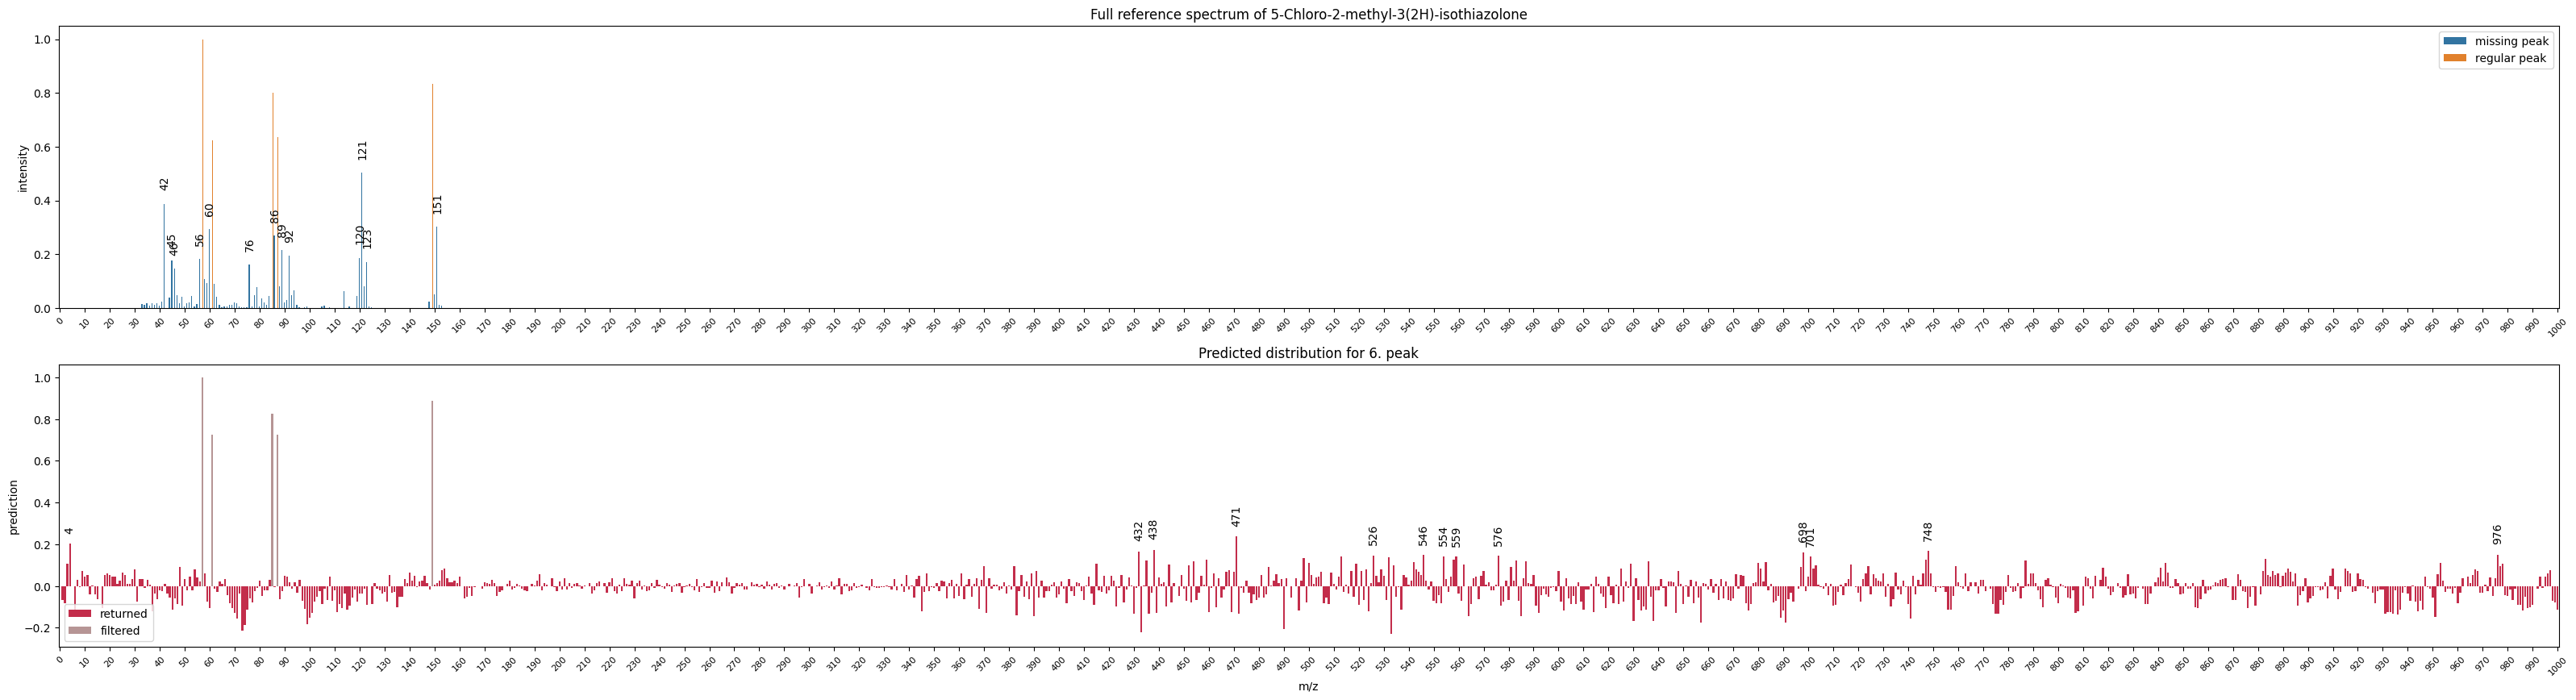

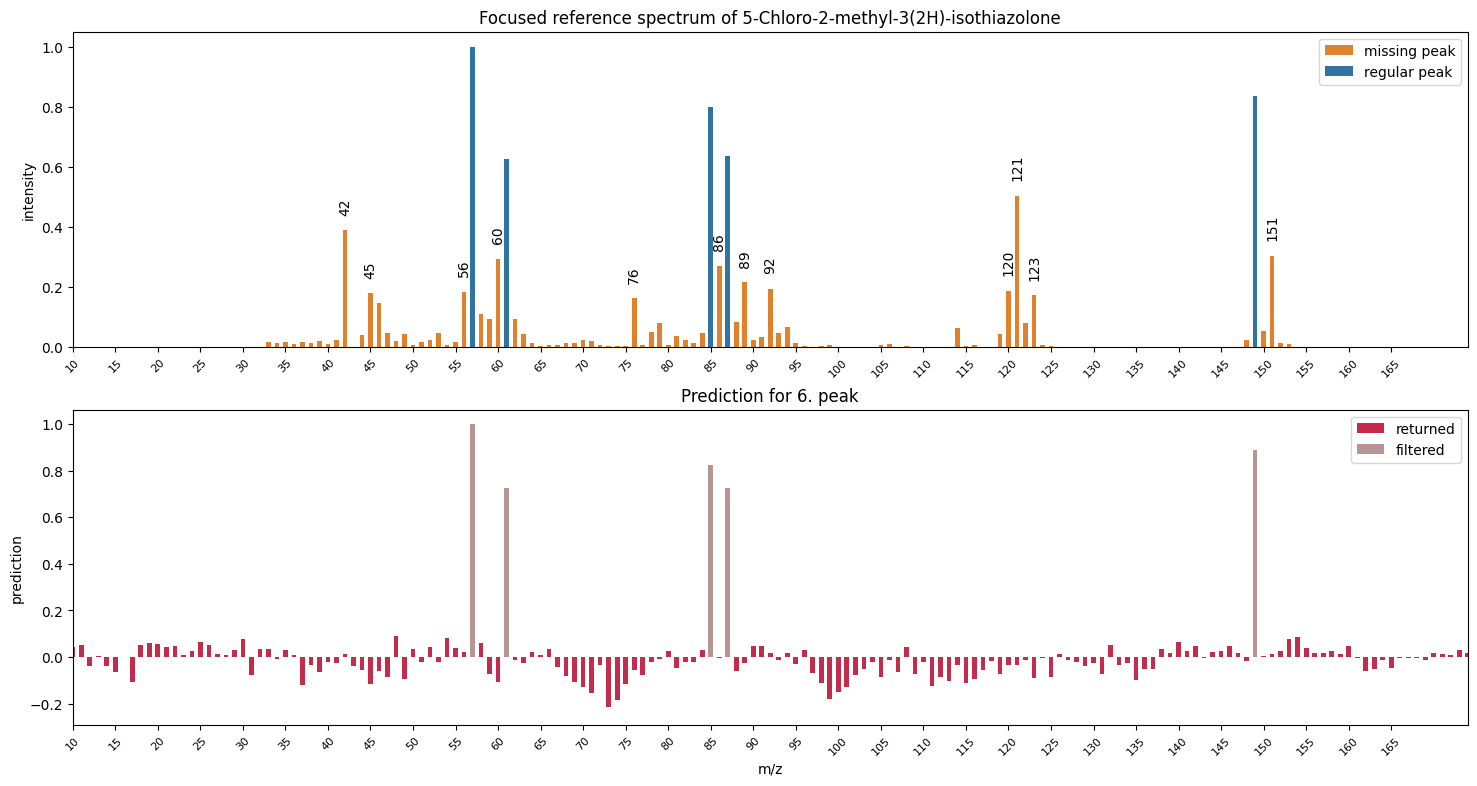

In [74]:
plot_ds = TopKDS(documents_val, vocab, k, onehot=False)
prob = predictor(plot_ds[i][0].reshape(1, *plot_ds[i][0].shape))[0]
plot_spectrum_predictions(plot_ds.ref_docs[i], k, prob, predictor.coder, plot_full=True)

## Model Selection
done on the val set

In [34]:
import os
from metrics import metrics_klj, metrics_intlj

predictors = {"g2vknn_peak": PredictorKNN(PeakKNN(w2v,index2relfreq=None), TextMzCoder, max_mz=None), 
              "g2vknn_spec": PredictorKNN(SpectralKNN(w2v, index2relfreq=None), TextMzCoder, max_mz=None)
             }


P_FOLDER = f"predictions/{kind}"
up_to_k = 30
l = 20

In [35]:
from model_evaluation import calc_predictions, load_predictions, model_selection
from visual_utils import plot_scores

In [56]:
%%time
calc_predictions(up_to_k, l, predictors, datasets, "gen_val", P_FOLDER, verbose=False)

peakknn


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


specknn


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


CPU times: user 23min 56s, sys: 817 ms, total: 23min 57s
Wall time: 23min 59s


In [ ]:
best_p_name, scores = model_selection(P_FOLDER, "gen_val", predictors=predictors, up_to_k=20, \
                                      l=4, j=6, to_rel_inten=.2, l_rel=None)

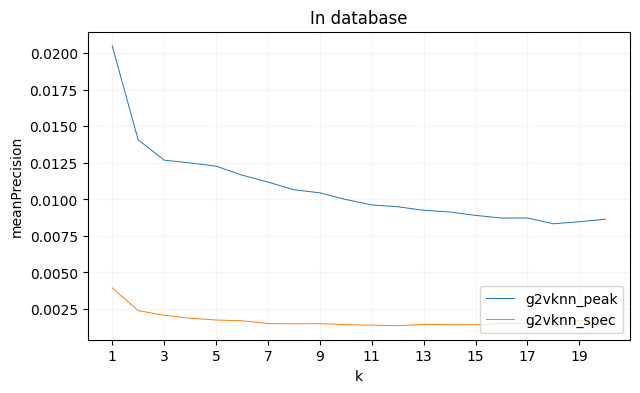

In [37]:
plot_scores(scores, metrics="mpi",
            orderer_f=None,hue_f=None,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "k", ylabel="meanPrecision",
            save_to_path=f"figures/{kind}/selection/g2vknn_topk_val_prec.pdf")

In [38]:
best_p_name

'g2vknn_peak'

## Visualisation of the best predictor

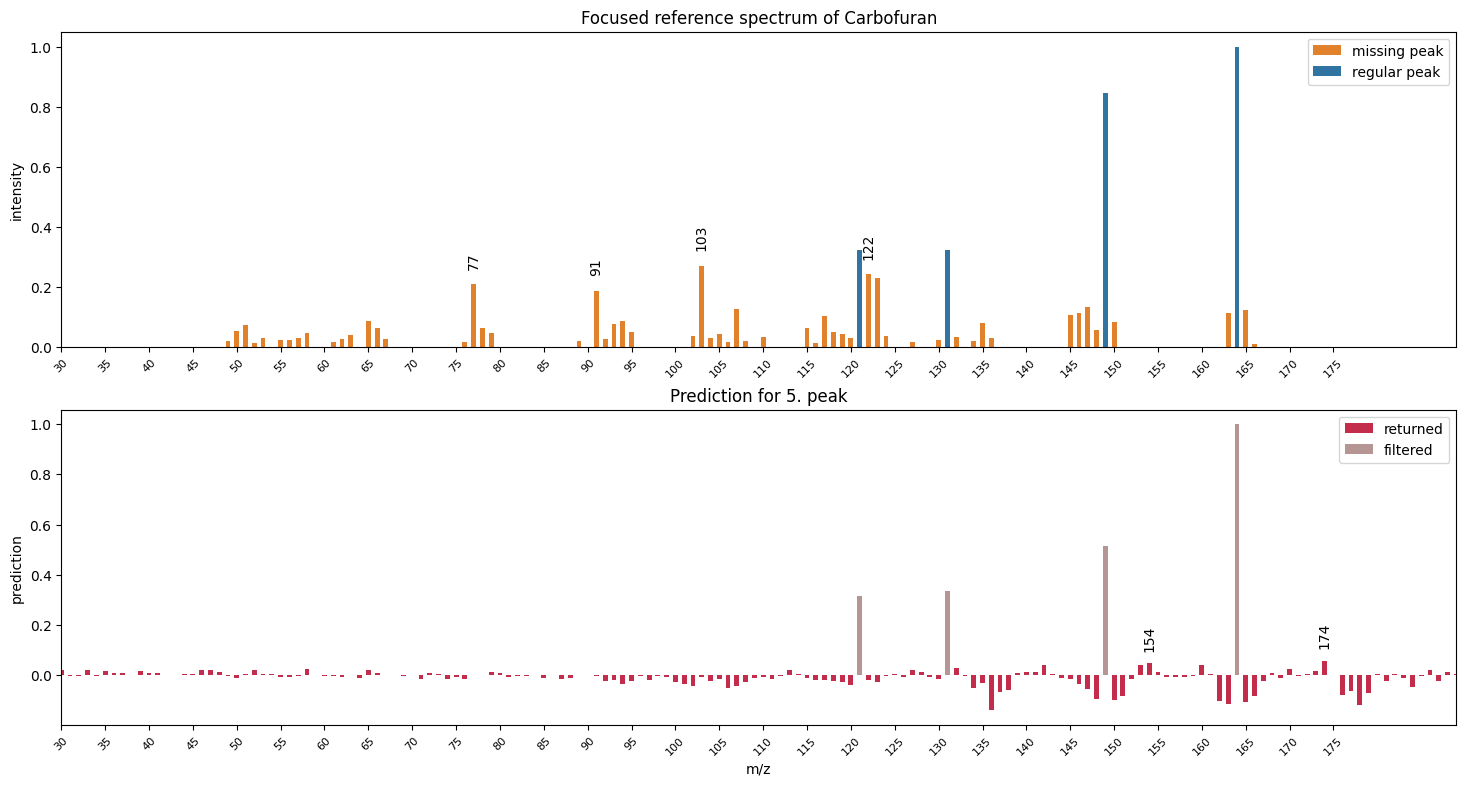

In [47]:
k = 4
i = 13766
plot_ds = TopKDS(documents_test, vocab, k, onehot=False, add_intensity=True)
prob = predictors[best_p_name](plot_ds[i][0].reshape(1, *plot_ds[i][0].shape))[0]
plot_spectrum_predictions(plot_ds.ref_docs[i], k, prob, \
                         predictors[best_p_name].coder,\
                         plot_full=False, down_to=0.5,\
                         save_to_path=f"figures/{kind}/meta/down_to0.5.pdf")


In [ ]:
for i in range(len(documents_test)):
    if documents_test[i].metadata["name"] not in interesting:
        continue
    print(documents_test[i].metadata["name"])
    for k in [3,4,5,6,7,8]:
        plotDS = TopKDS(documents_test, k=k, vocab=vocab, onehot=False, add_intensity=True)
        pred = predictors[best_p_name](plotDS[i][0].reshape(1, *plotDS[i][0].shape))[0]

        plot_spectrum_predictions(documents_test[i], k, pred, predictors[best_p_name].coder,\
                                  plot_full=False, \
                                  save_to_path=f"figures/{kind}/visual/g2vknn_test_{i}_top{k}.pdf")


## Detailed evaluation of the best predictor 
done on the test set

In [26]:
%%time
up_to_k = 30
l = 20

calc_predictions(up_to_k, l, {best_p_name: predictors[best_p_name]}, datasets, \
                 "gen_test", P_FOLDER, verbose=False)

g2vknn_peak


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


CPU times: user 6min 22s, sys: 828 ms, total: 6min 23s
Wall time: 6min 24s


g2vknn_peak
Possible k up to 30, predict up to 20 peaks
Selected up to k=30, l=4, j=6
[22564 22564 22564 22564 22532 22501 22452 22410 22357 22280 22206 22125
 22020 21920 21801 21657 21522 21385 21218 21040 20846 20639 20440 20266
 20045 19857 19653 19446 19253 19029]
[22564 22564 22564 22564 22532 22501 22452 22410 22357 22280 22206 22125
 22020 21920 21801 21657 21522 21385 21218 21040 20846 20639 20440 20266
 20045 19857 19653 19446 19253 19029]
Selected up to k=30, l=None, to_rel_inten=0.2
[21122 22328 22520 22555 22561 22559 22562 22562 22563 22530 22501 22451
 22408 22354 22277 22205 22122 22016 21919 21799 21656 21519 21381 21214
 21040 20846 20638 20437 20264 20044]
[21122 22328 22520 22555 22561 22559 22562 22562 22563 22530 22501 22451
 22408 22354 22277 22205 22122 22016 21919 21799 21656 21519 21381 21214
 21040 20846 20638 20437 20264 20044]


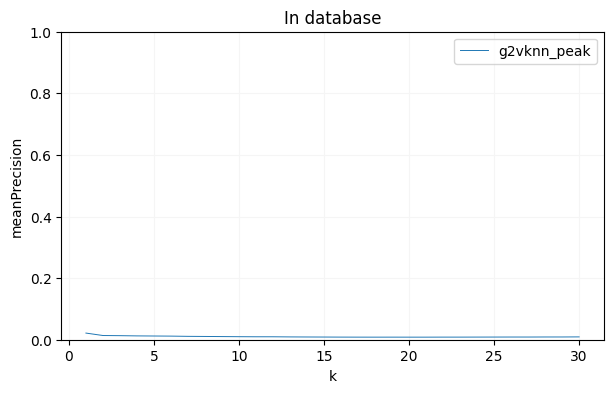

In [32]:
best_p_name, scores_test = model_selection(P_FOLDER, "gen_test", \
                                           predictors={best_p_name: predictors[best_p_name]}, up_to_k=30, \
                                           l=4, j=6, to_rel_inten=.2, l_rel=None)

plot_scores(scores_test, metrics="mpi",
            orderer_f=None,hue_f=None,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "k", ylabel="meanPrecision",
            save_to_path=f"figures/{kind}/selection/g2vknn_test_prec.pdf")